In [62]:
import pandas as pd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pathlib import Path

base_path = Path("~/Git/stable-diffusion/outputs_lukas").expanduser()


metric_files = glob.glob(os.path.join(base_path, "**", "metrics.csv"), recursive=True)

run_names = ["/".join(os.path.dirname(f).split("/")[-2:]) for f in metric_files]
dfs = {name: pd.read_csv(f) for name, f in zip(run_names, metric_files)}

for df in dfs.values():
    if "pref_score" in df and df["pref_score"].max() > 100:
        df["pref_score"] = df["pref_score"] / 100

#colors = ["tab:blue", "tab:blue", "tab:orange", "tab:orange", "tab:green", "tab:green", "tab:red", "tab:red", "tab:purple", "tab:purple", "tab:brown", "tab:brown", "tab:pink", "tab:pink", "tab:gray", "tab:gray", "tab:olive", "tab:olive", "tab:cyan", "tab:cyan"]
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"] * 20


settings = {
    name: {
        "color": color,
        "label": name,
    } for i, (name, color) in enumerate(zip(run_names, colors))
}


In [63]:
list(dfs.values())[0].keys()

Index(['round', 'prompt', 'prompt_idx', 'image_idx', 'image', 'pref_score',
       'pos_sim', 'neg_sim', 'seed', 'liked', 'disliked'],
      dtype='object')

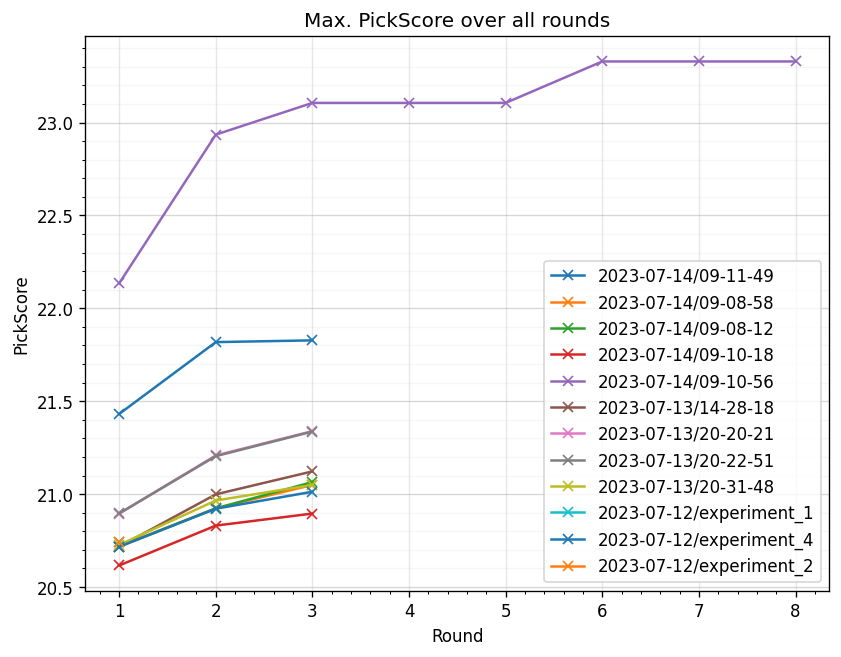

In [72]:
y_key = "pref_score"
y_label = "PickScore"
y_title = "PickScore"

#runs = set(dfs.keys()) - set(["2023-07-14/09-10-56", "2023-07-14/09-10-56", "2023-07-12/experiment_1", "2023-07-12/experiment_2"])
runs = dfs.keys()

data = {}
for name in runs:
    df = dfs[name]
    rounds = sorted(df["round"].unique())
    ys = [df.loc[df["round"] <= i].groupby(["prompt_idx"])[y_key].max().mean() for i in rounds]
    data[name] = ys

key = next(iter(data.keys()))
#assert all(len(v) == len(data[key]) for v in data.values())

plt.figure(dpi=120, figsize=(8, 6))

for name, ys in data.items():
    #plt.plot(xs, ys, label=settings[name]["label"], color=settings[name]["color"], linestyle=settings[name]["linestyle"], marker=settings[name]["marker"])
    plt.plot(np.arange(len(ys)) + 1, ys, label=settings[name]["label"], marker="x")

xs = np.arange(max(len(v) for v in data.values())) + 1
plt.xticks(xs)
plt.yticks()
plt.xlabel("Round")
plt.ylabel(y_label)
plt.legend(loc="lower right")
plt.minorticks_on()
plt.grid(axis="y", linestyle="-", alpha=0.5, which="major")
plt.grid(axis="y", linestyle="-", alpha=0.1, which="minor")
plt.grid(axis="x", linestyle="-", alpha=0.3, which="major")
plt.title(f"Max. {y_title} over all rounds")
plt.savefig(f"max_{y_key}_so_far.pdf", bbox_inches="tight")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


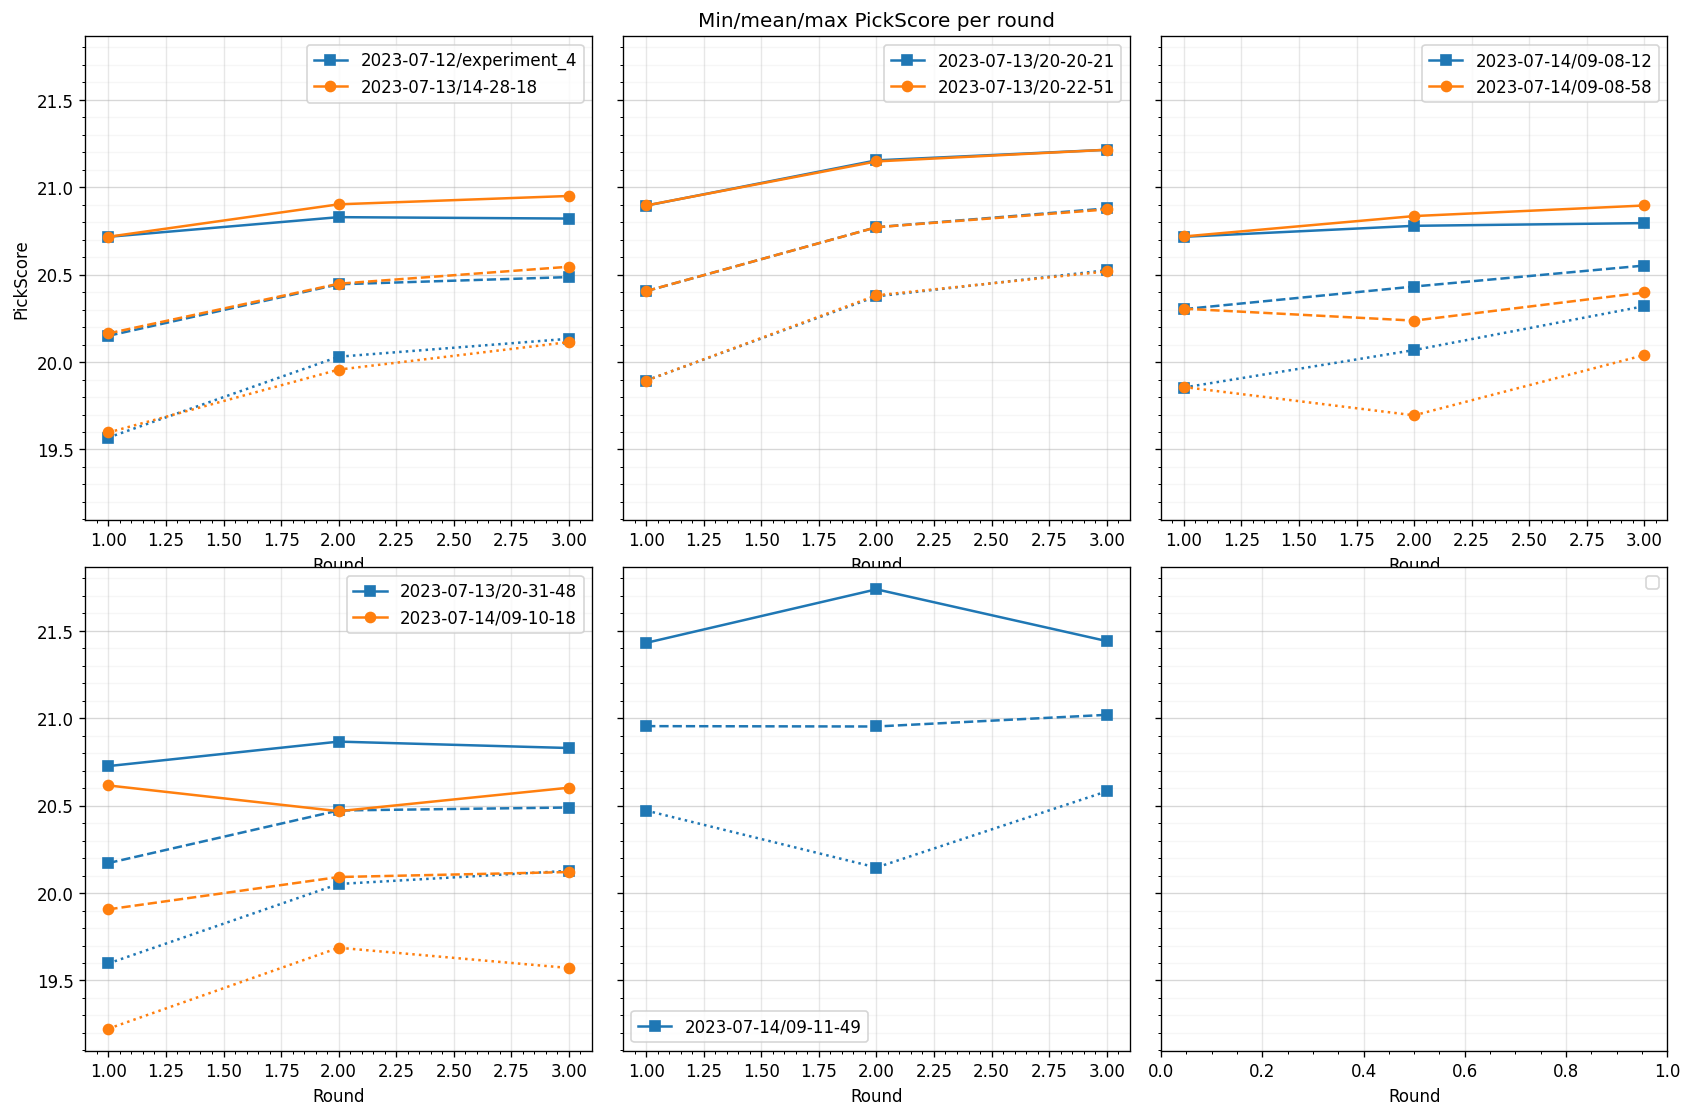

In [84]:
runs = [
    '2023-07-12/experiment_4',
    '2023-07-13/14-28-18',
    '2023-07-13/20-20-21',
    '2023-07-13/20-22-51',
    '2023-07-14/09-08-12',
    '2023-07-14/09-08-58',
    '2023-07-13/20-31-48',
    '2023-07-14/09-10-18',
    '2023-07-14/09-11-49',
    #'2023-07-14/09-10-56',
    #'2023-07-12/experiment_1',
    #'2023-07-12/experiment_2',
]

y_key = "pref_score"
y_label = "PickScore"
y_title = "PickScore"

min_data = {}
mean_data = {}
max_data = {}
for label, df in dfs.items():
    group = df.groupby(["prompt_idx", "round"])[y_key]
    min_data[label] = group.min().groupby("round").mean()
    mean_data[label] = group.mean().groupby("round").mean()
    max_data[label] = group.max().groupby("round").mean()

n_rows = (len(runs) - 1) // 6 + 1
fig, axs = plt.subplots(n_rows, 3, sharey=True, dpi=120, figsize=(14, 4 * n_rows + 1))
axs = axs.flatten()

legend_elements = []

for i, name in enumerate(runs):
    #plt.subplot(1, 3, i//2 + 1)
    ax = axs[i//2]
    color = colors[i % 2]
    marker = ["s", "o"][i % 2]
    xs = np.arange(len(min_data[name])) + 1
    ax.plot(xs, min_data[name], linestyle="dotted", marker=marker, color=color)
    ax.plot(xs, mean_data[name], linestyle="dashed", marker=marker, color=color)
    ax.plot(xs, max_data[name], linestyle="solid", marker=marker, label=settings[name]["label"], color=color)
    # ax.plot([], [], label=settings[name]["label"], color=color, linestyle="solid", marker="x")

    #legend_elements.append(Line2D([], [], color=color, linestyle="solid", label=settings[name]["label"], marker=marker))

group_legend_elements = [
    # Line2D([], [], linestyle="", label=''),
    Line2D([], [], color='dimgray', linestyle="solid", label='max'),
    Line2D([], [], color='dimgray', linestyle="dashed", label='mean'),
    Line2D([], [], color='dimgray', linestyle="dotted", label='min'),
]


fig.tight_layout()
axs[0].set_ylabel(y_label)
plt.subplot(n_rows, 3, 2)
plt.title(f"Min/mean/max {y_title} per round")
#group_legend = plt.legend(handles=group_legend_elements, loc="lower right")
# plt.legend(handles=legend_elements, loc="upper left", bbox_to_anchor=(-0.01, -0.05), ncol=3, frameon=False)
#plt.gca().add_artist(group_legend)
for ax in axs:
    #ax.set_xticks(xs)
    ax.set_xlabel("Round")
    ax.legend()
    ax.minorticks_on()
    ax.grid(axis="y", linestyle="-", alpha=0.5, which="major")
    ax.grid(axis="y", linestyle="-", alpha=0.1, which="minor")
    ax.grid(axis="x", linestyle="-", alpha=0.3, which="major")
plt.savefig(f"{y_key}_per_round.pdf", bbox_inches="tight")

In [79]:
list(dfs.keys())

['2023-07-14/09-11-49',
 '2023-07-14/09-08-58',
 '2023-07-14/09-08-12',
 '2023-07-14/09-10-18',
 '2023-07-14/09-10-56',
 '2023-07-13/14-28-18',
 '2023-07-13/20-20-21',
 '2023-07-13/20-22-51',
 '2023-07-13/20-31-48',
 '2023-07-12/experiment_1',
 '2023-07-12/experiment_4',
 '2023-07-12/experiment_2']